# LSTM + Conv2D 模型结构

## 1. 输入数据
- **形状**: (Batch, Time, Features, 1)
- 在进入卷积层前，重塑为 (Batch, 1, Time, Features)，以匹配 Conv2D 输入格式。

## 2. 卷积前端
1. **卷积块 1 & 2**:
   - 1×2 Conv2D（融合相邻价量特征）
   - 4×1 Conv2D（捕捉短期时间模式）
   - LeakyReLU 激活
2. **卷积块 3**:
   - 1×10 Conv2D（聚合全部剩余特征）
   - 4×1 Conv2D
3. **Inception 模块**:
   - 分支 1: 1×1 Conv2D → 3×1 Conv2D
   - 分支 2: 1×1 Conv2D → 5×1 Conv2D
   - 分支 3: MaxPool(3×1) → 1×1 Conv2D
   - 在通道维度拼接，融合多尺度时间信息。

## 3. LSTM 序列处理
- 将 Inception 输出重塑为 (Batch, Time, Channels)。
- 输入单层 LSTM，建模长程依赖。
- 取最后时间步隐藏状态作为序列表示。

## 4. 分类输出头
- Drop


# Transformer + Conv1D 模型结构

## 1. 输入数据
- **形状**: (Batch, Time, Features, 1)
- 在进入卷积层前，重塑为 (Batch, Features, Time)，以匹配 Conv1D 输入格式。

## 2. 卷积前端
1. **卷积块 1**:
   - Conv1D(32, kernel_size=3) → BatchNorm1d → LeakyReLU
2. **卷积块 2**:
   - Conv1D(64, kernel_size=3) → BatchNorm1d → LeakyReLU
   - AvgPool1d(时间维度减半)
3. **1D Inception 模块**:
   - 分支 1: Conv1D(64, kernel_size=3)
   - 分支 2: Conv1D(64, kernel_size=5)
   - 分支 3: MaxPool1d(kernel_size=3) → Conv1D(64, kernel_size=1)
   - 将三个分支的输出在通道维度拼接，得到通道数 192 的特征图。

## 3. Transformer 后端
- 重塑为 (Batch, Time_out, d_model=192)。
- 添加可学习的 **[CLS] Token**。
- 加入正弦/余弦位置编码。
- 堆叠多层 Transformer Encoder，每层包含：
  - 多头自注意力（Multi-Head Self-Attention）
  - 前馈神经网络（Feed-Forward Network）

## 4. 分类输出头
- 取 [CLS] Token 的最终表示。
- Dropout(0.5)
- Linear 输出到 3 类（下降、不变、上升）的 logits。


下载中文字体

↘︎ 下载: https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf
已保存: NotoSansCJKsc-Regular.otf  (16052 KB)
 已启用中文字体： Noto Sans CJK SC


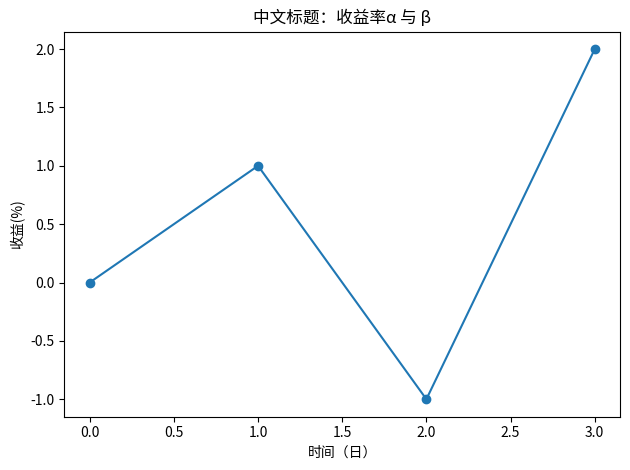

In [1]:
# === 一次性：下载中文字体 → 注册 → 配置 Matplotlib → 测试中文 ===
import os, sys, time, urllib.request
import matplotlib as mpl
from matplotlib import font_manager
import matplotlib.pyplot as plt

#  备选字体下载地址（按优先级尝试）
CANDIDATES = [
    # Noto Sans CJK SC
    ("NotoSansCJKsc-Regular.otf",
     "https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf"),
    ("NotoSansCJKsc-Regular.otf",
     "https://raw.githubusercontent.com/googlefonts/noto-cjk/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf"),
    # Source Han Sans SC (思源黑体)
    ("SourceHanSansSC-Regular.otf",
     "https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/SimplifiedChinese/SourceHanSansSC-Regular.otf"),
]

def try_download(dest, url, timeout=25):
    try:
        print(f"↘︎ 下载: {url}")
        urllib.request.urlretrieve(url, dest)
        # 简单验收：大小>100KB
        if os.path.getsize(dest) < 100 * 1024:
            raise RuntimeError("下载文件异常（过小）")
        print(f"已保存: {dest}  ({os.path.getsize(dest)/1024:.0f} KB)")
        return True
    except Exception as e:
        print(f"下载失败: {e}")
        if os.path.exists(dest):
            try: os.remove(dest)
            except: pass
        return False

# 2) 若本地已存在可用字体，直接用；否则逐个下载尝试
font_path = None
for fname, url in CANDIDATES:
    if os.path.exists(fname):
        font_path = fname
        print(f"已有字体文件: {fname}")
        break
else:
    for fname, url in CANDIDATES:
        if try_download(fname, url):
            font_path = fname
            break

if not font_path:
    raise RuntimeError(" 无法下载中文字体。请检查网络/代理，或手动上传任一 OTF/TTF 后重试。")

# 3) 注册字体并设为默认 sans-serif
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()

mpl.rcParams["font.sans-serif"] = [font_name]
mpl.rcParams["axes.unicode_minus"] = False
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42
mpl.rcParams["svg.fonttype"] = "none"

print(" 已启用中文字体：", font_name)

# 4) 画一张测试图
plt.figure()
plt.title("中文标题：收益率α 与 β")
plt.xlabel("时间（日）")
plt.ylabel("收益(%)")
plt.plot([0,1,2,3],[0,1,-1,2], marker="o")
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import os
import pickle
import re
from typing import List, Union, Tuple


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Replace TensorFlow imports with PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset



设置全局参数，这里我们选择日期

In [3]:
# 全局参数设置
# 数据日期范围参数
START_DATE = '2024-12-1'  # 数据开始日期
END_DATE = '2024-12-31'    # 数据结束日期

# 期货品种设置
SYMBOL_TYPES = ['IM']  # 暂时不能并行训练

# 类别映射
CLASS_MAPPING = {-1: "下降", 0: "不变", 1: "上升"}
CLASS_LABELS = ["下降", "不变", "上升"]

# 数据处理参数
LOOKBACK_WINDOW = 5  # 用于计算标准化参数的历史天数
TIMESTAMP_PER_SAMPLE = 10  # 每个样本的时间步长
K = 3  # 用于计算未来价格走势的时间步长
ALPHA = 2.93e-5  # 价格变化阈值，用于生成标签

# 数据缓存路径
DATA_CACHE_DIR = "./data_cache"
os.makedirs(DATA_CACHE_DIR, exist_ok=True)

In [4]:

from google.colab import drive
drive.mount('/content/drive')


# 定义新的数据获取函数
def get_processed_data(
    start_date: Union[str, np.datetime64, pd.Timestamp],
    end_date: Union[str, np.datetime64, pd.Timestamp] = None,
    symbol_types: List[str] = SYMBOL_TYPES,
    time_range: Tuple[str, str] = None,
    # 1) 挂载 Google Drive


    # 2) 直接把路径改成你在 Drive 里的真实位置
    parquet_path = '/content/drive/MyDrive/IM00_subset.parquet'  # 自己换成实际目录

) -> pd.DataFrame:
    """
    从本地Parquet文件获取并处理期货数据。
    本版本已修正以正确处理 'YYYYMMDD' 日期格式和 'HHMMSSsss' 时间格式。
    """
    # 1. 加载数据
    try:
        print(f"正在从 '{parquet_path}' 加载数据...")
        df = pd.read_parquet(parquet_path)
        print(f"数据加载成功，共 {len(df)} 条记录。")
    except FileNotFoundError:
        print(f"错误：未找到文件 '{parquet_path}'。请确保文件路径正确。")
        return pd.DataFrame()

    # 2. 预处理和参数格式化
    if end_date is None:
        end_date = start_date
    start_date_for_filter = pd.to_datetime(start_date).strftime('%Y%m%d')
    end_date_for_filter = pd.to_datetime(end_date).strftime('%Y%m%d')
    print(f"将使用筛选日期范围: {start_date_for_filter} 到 {end_date_for_filter}")

    df['MDDate'] = df['MDDate'].astype(str)
    df['MDTime'] = df['MDTime'].astype(str)
    df['Symbol'] = df['Symbol'].astype(str)

    # 【关键修正】：使用完全匹配的 'HHMMSSsss' 时间格式
    print("正在高效转换时间戳...")
    datetime_format = '%Y%m%d %H%M%S%f' # 注意：时间部分没有分隔符
    df['Timestamp'] = pd.to_datetime(df['MDDate'] + ' ' + df['MDTime'],
                                     format=datetime_format,
                                     errors='coerce')
    df.dropna(subset=['Timestamp'], inplace=True)
    print("时间戳转换完成。")

    # 3. 按日期和合约类型筛选
    print(f"正在按日期 ({start_date_for_filter} to {end_date_for_filter}) 和合约类型 ({symbol_types}) 筛选数据...")
    date_mask = df['MDDate'].between(start_date_for_filter, end_date_for_filter)
    symbol_mask = df['Symbol'].str.strip().str.startswith(tuple(symbol_types))

    result_df = df[date_mask & symbol_mask].copy()

    if result_df.empty:
        print(f"在 {start_date_for_filter} 到 {end_date_for_filter} 范围内未找到合约类型为 {symbol_types} 的数据。")
        return pd.DataFrame()
    print(f"初步筛选后，找到 {len(result_df)} 条记录。")

    # 4. 按交易时间范围筛选
    if time_range is not None:
        start_time_obj = pd.to_datetime(time_range[0]).time()
        end_time_obj = pd.to_datetime(time_range[1]).time()
        time_condition = (result_df['Timestamp'].dt.time >= start_time_obj) & \
                         (result_df['Timestamp'].dt.time <= end_time_obj)
    else:
        morning_session = (result_df['Timestamp'].dt.time >= pd.to_datetime("09:30:00").time()) & \
                          (result_df['Timestamp'].dt.time <= pd.to_datetime("11:30:00").time())
        afternoon_session = (result_df['Timestamp'].dt.time >= pd.to_datetime("13:00:00").time()) & \
                            (result_df['Timestamp'].dt.time <= pd.to_datetime("15:00:00").time())
        time_condition = morning_session | afternoon_session

    result_df = result_df[time_condition].copy()
    print(f"经过交易时间筛选后，剩余 {len(result_df)} 条记录。")

    # 5. 重命名列
    rename_map = {
        'MDDate': 'Trade_Date',
        'MDTime': 'm_time',
        'Buy1Price': 'BidPrice1', 'Buy1OrderQty': 'BidVolume1', 'Sell1Price': 'AskPrice1', 'Sell1OrderQty': 'AskVolume1',
        'Buy2Price': 'BidPrice2', 'Buy2OrderQty': 'BidVolume2', 'Sell2Price': 'AskPrice2', 'Sell2OrderQty': 'AskVolume2',
        'Buy3Price': 'BidPrice3', 'Buy3OrderQty': 'BidVolume3', 'Sell3Price': 'AskPrice3', 'Sell3OrderQty': 'AskVolume3',
        'Buy4Price': 'BidPrice4', 'Buy4OrderQty': 'BidVolume4', 'Sell4Price': 'AskPrice4', 'Sell4OrderQty': 'AskVolume4',
        'Buy5Price': 'BidPrice5', 'Buy5OrderQty': 'BidVolume5', 'Sell5Price': 'AskPrice5', 'Sell5OrderQty': 'AskVolume5',
    }
    # 为了下游兼容性，我们把原始的 'YYYYMMDD' 日期格式化为 'YYYY-MM-DD'
    result_df['MDDate'] = result_df['Timestamp'].dt.strftime('%Y-%m-%d')
    result_df.rename(columns=rename_map, inplace=True)

    # 6. 选择并返回最终需要的列
    required_columns = list(rename_map.values()) + ['Symbol']
    final_cols = [col for col in required_columns if col in result_df.columns]

    return result_df[final_cols]

# 辅助函数：计算移动平均
def moving_average(x, k):
    """计算k个时间点的移动平均"""
    return np.convolve(x, np.ones(k), 'valid') / k


Mounted at /content/drive


按照中间价来算y，然后手搓一些特征因子当作x

In [5]:

# 生成标签
def generate_labels(k, alpha, daily_data_dict):
    """
    根据未来k个时间点的价格变化生成标签

    参数:
    k: 未来k个时间点
    alpha: 价格变化阈值
    daily_data_dict: 每日数据字典

    返回:
    包含每日标签的字典
    """
    daily_label_dict = {}
    for date in daily_data_dict.keys():
        # 提取bid和ask价格和数量
        ask_price1 = daily_data_dict[date]['AskPrice1'].values
        ask_volume1 = daily_data_dict[date]['AskVolume1'].values
        bid_price1 = daily_data_dict[date]['BidPrice1'].values
        bid_volume1 = daily_data_dict[date]['BidVolume1'].values

        # 计算加权中间价
        mid_price = (ask_price1 + bid_price1) / 2


        # 计算未来k个时间点的平均价格
        future_k_avg_mid_price = moving_average(mid_price, k)[1:]

        # 计算价格变化百分比
        change_pct = (future_k_avg_mid_price - mid_price[:-k]) / mid_price[:-k]

        # 生成标签: -1(下跌), 0(不变), 1(上涨)
        y_label = (-(change_pct < -alpha).astype(int)) + (change_pct > alpha).astype(int)

        daily_label_dict[date] = y_label.reshape(-1, 1)

    return daily_label_dict

# 准备训练数据
def prepare_orderbook_data(data_df):
    """
    从原始数据中提取订单簿特征，并加入动量、波动率、OFI等高阶特征。
    这是一个增强版本，旨在为模型提供更丰富、更具预测能力的信息。

    参数:
    data_df: 原始数据DataFrame，包含5档量价信息。

    返回:
    包含所有特征的numpy数组，形状为 (样本数, 特征数)。
    """
    # 存储所有特征的列表
    features = []

    # =========================================================================
    # 1. 原始基础特征 (共 20 个)
    # =========================================================================
    # 提取Ask价格和数量 (5档)
    for i in range(1, 6):
        features.append(data_df[f'AskPrice{i}'].values)
        features.append(data_df[f'AskVolume{i}'].values)

    # 提取Bid价格和数量 (5档)
    for i in range(1, 6):
        features.append(data_df[f'BidPrice{i}'].values)
        features.append(data_df[f'BidVolume{i}'].values)

    # =========================================================================
    # 2. 原始衍生特征 (共 29 个)
    # =========================================================================
    # 2.1 价差特征 - 各档位间价差 (8个)
    for i in range(1, 5):
        features.append(data_df[f'AskPrice{i+1}'].values - data_df[f'AskPrice{i}'].values)
        features.append(data_df[f'BidPrice{i}'].values - data_df[f'BidPrice{i+1}'].values)

    # 2.2 中间价 (5个)
    for i in range(1, 6):
        mid_price = (data_df[f'AskPrice{i}'].values + data_df[f'BidPrice{i}'].values) / 2
        features.append(mid_price)

    # 2.3 买卖价差 (5个)
    for i in range(1, 6):
        features.append(data_df[f'AskPrice{i}'].values - data_df[f'BidPrice{i}'].values)

    # 2.4 累计量特征 (10个)
    ask_cum_vol = np.zeros(len(data_df))
    bid_cum_vol = np.zeros(len(data_df))
    for i in range(1, 6):
        ask_cum_vol += data_df[f'AskVolume{i}'].values
        bid_cum_vol += data_df[f'BidVolume{i}'].values
        features.append(ask_cum_vol.copy())
        features.append(bid_cum_vol.copy())

    # 2.5 买卖量比 (1个)
    features.append(bid_cum_vol / (ask_cum_vol + bid_cum_vol + 1e-10))

    # =========================================================================
    # 3. 新增高阶特征 (共 10 个)
    # =========================================================================

    # --- 准备用于计算的基础数据 ---
    mid_price_l1 = (data_df['BidPrice1'].values + data_df['AskPrice1'].values) / 2

    # 3.1 动量 (Momentum) 特征 (3个)
    # 衡量价格变化的速度和方向
    price_change = np.diff(mid_price_l1, prepend=mid_price_l1[0])
    for window in [5, 10, 20]:
        # min_periods=1 确保从第一个有效值开始计算，fillna(0) 填充初始NaN
        momentum = pd.Series(price_change).rolling(window=window, min_periods=1).sum().fillna(0).values
        features.append(momentum)

    # 3.2 波动率 (Volatility) 特征 (3个)
    # 衡量价格波动的剧烈程度
    returns = pd.Series(mid_price_l1).pct_change().fillna(0)
    for window in [10, 30, 60]:
        volatility = returns.rolling(window=window, min_periods=1).std().fillna(0).values
        features.append(volatility)

    # 3.3 订单流不平衡 (Order Flow Imbalance, OFI) 特征 (4个)
    # 衡量主动性买卖压力，是价格变动的直接驱动力

    # 获取上一时刻的盘口价格
    prev_bid_price = data_df['BidPrice1'].shift(1).fillna(method='bfill')
    prev_ask_price = data_df['AskPrice1'].shift(1).fillna(method='bfill')

    # 计算盘口挂单量的变化
    delta_bid_vol = data_df['BidVolume1'].diff().fillna(0)
    delta_ask_vol = data_df['AskVolume1'].diff().fillna(0)

    # 规则1: 买一价上涨，意味着买方主动吃掉卖单，产生买方压力
    ofi_raw = np.where(data_df['BidPrice1'] > prev_bid_price, data_df['BidVolume1'], 0.0)

    # 规则2: 卖一价下跌，意味着卖方主动砸穿买单，产生卖方压力
    ofi_raw = np.where(data_df['AskPrice1'] < prev_ask_price, -data_df['AskVolume1'], ofi_raw)

    # 规则3: 价格稳定时，OFI由挂单量的变化体现
    is_price_stable = (data_df['BidPrice1'] == prev_bid_price) & (data_df['AskPrice1'] == prev_ask_price)
    ofi_raw = np.where(is_price_stable, delta_bid_vol - delta_ask_vol, ofi_raw)

    # 添加瞬时OFI作为特征
    features.append(ofi_raw)

    # 添加不同窗口下的累积OFI作为特征，更能反映一段时间内的持续压力
    for window in [10, 30, 60]:
        ofi_sum = pd.Series(ofi_raw).rolling(window=window, min_periods=1).sum().fillna(0).values
        features.append(ofi_sum)

    # =========================================================================
    # 最终处理
    # =========================================================================
    # 将所有特征（一个包含多个numpy数组的列表）合并成一个大的2D numpy数组
    # 并转置，使得每一行是一个时间点的样本，每一列是一个特征
    return np.array(features).T


从原始 Parquet 数据里提取指定日期范围的数据（get_processed_data）；

按交易日分组，每日生成特征矩阵（prepare_orderbook_data）；

按滚动窗口（LOOKBACK_WINDOW）计算每日的标准化均值/标准差；

用这些参数把当日的特征矩阵标准化，得到 daily_norm_data_dict；

用 generate_labels 生成标签；

把这些结果按品种打包进 result_by_symbol 返回。

In [6]:

# 处理多日数据并计算标准化参数
def process_multi_day_data(start_date, end_date=None, symbol_types=SYMBOL_TYPES):
    """
    处理多日数据，计算标准化参数，并准备训练数据
    每个品种分开处理，有自己的标准化参数和标签

    参数:
    start_date: 开始日期
    end_date: 结束日期，如果为None，则使用start_date加上LOOKBACK_WINDOW天
    symbol_types: 合约类型列表

    返回:
    包含每个品种处理后数据的字典:
    {
        '品种代码': {
            'daily_norm_data_dict': 标准化后的每日数据字典,
            'daily_label_dict': 每日标签字典,
            'norm_mean_dict': 标准化均值字典,
            'norm_stddev_dict': 标准化标准差字典
        }
    }
    """
    # 如果未指定结束日期，则使用开始日期加上足够的天数以满足LOOKBACK_WINDOW
    if end_date is None:
        # 转换为pandas时间戳以便进行日期计算
        start_ts = pd.to_datetime(start_date)
        # 考虑到可能有非交易日，多加几天以确保有足够的交易日
        end_ts = start_ts + pd.Timedelta(days=LOOKBACK_WINDOW + 5)
        end_date = end_ts.strftime("%Y-%m-%d")

    # 结果字典，按品种分组
    result_by_symbol = {}

    # 对每个品种分别处理
    for symbol_type in symbol_types:
        print(f"\n===== 处理品种: {symbol_type} =====")

        # 获取该品种的日期范围内的数据
        print(f"获取从 {start_date} 到 {end_date} 的 {symbol_type} 数据...")
        # *** 注意：调用已修改的函数，不再需要 s_ddb 参数 ***
        raw_data = get_processed_data(start_date, end_date, symbol_types=[symbol_type])

        if raw_data.empty:
            print(f"未获取到 {symbol_type} 的数据")
            continue

        # 按日期分组数据
        daily_data_dict = {}
        for date, group in raw_data.groupby('Trade_Date'):
            date_str = pd.to_datetime(date).strftime("%Y-%m-%d")
            daily_data_dict[date_str] = group.reset_index(drop=True)

        # 处理订单簿数据
        daily_orderbook_dict = {}
        for date in daily_data_dict.keys():
            daily_orderbook_dict[date] = prepare_orderbook_data(daily_data_dict[date])

        # 计算标准化参数
        normalization_mean_dict = {}
        normalization_stddev_dict = {}

        # 获取所有日期的列表并排序
        dates_list = sorted(list(daily_orderbook_dict.keys()))

        # 确保有足够的历史数据用于标准化
        if len(dates_list) <= LOOKBACK_WINDOW:
            print(f"警告: {symbol_type} 可用的交易日数量 ({len(dates_list)}) 少于 LOOKBACK_WINDOW ({LOOKBACK_WINDOW})")
            print("将使用所有可用数据进行标准化")

        # 对每个交易日计算标准化参数
        for i in range(LOOKBACK_WINDOW, len(dates_list)):
            date = dates_list[i]

            if (date not in normalization_mean_dict.keys()) or (date not in normalization_stddev_dict.keys()):
                # 获取前LOOKBACK_WINDOW天的数据
                look_back_dates_list = dates_list[(i-LOOKBACK_WINDOW):i]
                prev_days_orderbook_np = None

                for look_back_date in look_back_dates_list:
                    if prev_days_orderbook_np is None:
                        prev_days_orderbook_np = daily_orderbook_dict[look_back_date]
                    else:
                        prev_days_orderbook_np = np.vstack((prev_days_orderbook_np, daily_orderbook_dict[look_back_date]))

                # 分别计算每个特征的均值和标准差
                feature_means = np.mean(prev_days_orderbook_np, axis=0)
                feature_stds = np.std(prev_days_orderbook_np, axis=0)

                # 确保标准差不为零，避免除零错误
                feature_stds[feature_stds < 1e-8] = 1.0

                # 保存标准化参数
                normalization_mean_dict[date] = feature_means
                normalization_stddev_dict[date] = feature_stds

        # 标准化数据
        daily_norm_data_dict = {}
        for i in range(LOOKBACK_WINDOW, len(dates_list)):
            date = dates_list[i]
            if date not in daily_norm_data_dict.keys():
                daily_norm_data_dict[date] = (daily_orderbook_dict[date] - normalization_mean_dict[date]) / normalization_stddev_dict[date]

        # 生成标签
        daily_label_dict = generate_labels(K, ALPHA, daily_data_dict)


        # 方便后面回测用的raw


        # 将该品种的处理结果存入结果字典
        result_by_symbol[symbol_type] = {
            'daily_norm_data_dict': daily_norm_data_dict,
            'daily_label_dict': daily_label_dict,
            'norm_mean_dict': normalization_mean_dict,
            'norm_stddev_dict': normalization_stddev_dict,

        }

        print(f"{symbol_type} 数据处理完成，可用日期: {sorted(list(daily_norm_data_dict.keys()))}")

    return result_by_symbol


然后我们生成时间序列模型的训练数据和标签。它从每日标准化数据和标签中提取特征，并且stack一下，按时间步创建样本，并将标签转换为 one-hot 编码格式，最终返回适配 CNN 输入格式的特征数据和对应的分类标签，用于模型训练。

In [7]:

# 生成训练和测试数据
def generate_X_y(daily_norm_data_dict, daily_label_dict):
    """
    生成模型的输入X和输出y

    参数:
    daily_norm_data_dict: 标准化后的每日数据字典
    daily_label_dict: 每日标签字典

    返回:
    X: 模型输入，形状为(样本数, 时间步, 特征数, 1)
    y: 模型输出，one-hot编码形式
    """
    # 合并所有日期的数据
    data_x = None
    for date in daily_norm_data_dict.keys():
        if date in daily_label_dict:  # 确保有对应的标签
            if data_x is None:
                data_x = daily_norm_data_dict[date].copy()[:-K, :]
            else:
                data_x = np.vstack((data_x, daily_norm_data_dict[date][:-K, :]))

    if data_x is None:
        print("没有足够的数据生成训练样本")
        return None, None

    print(f"特征数据形状: {data_x.shape}")

    # 合并所有日期的标签
    data_y = None
    for date in daily_label_dict.keys():
        if date in daily_norm_data_dict:  # 确保有对应的标准化数据
            if data_y is None:
                data_y = daily_label_dict[date].copy()
            else:
                data_y = np.vstack((data_y, daily_label_dict[date]))

    print(f"标签数据形状: {data_y.shape}")

    # 检查数据和标签的长度是否匹配
    if data_x.shape[0] != data_y.shape[0]:
        print(f"警告: 特征数据长度 ({data_x.shape[0]}) 与标签长度 ({data_y.shape[0]}) 不匹配")
        min_len = min(data_x.shape[0], data_y.shape[0])
        data_x = data_x[:min_len]
        data_y = data_y[:min_len]

    [N, P_x] = data_x.shape

    # 创建时间序列样本
    x = np.zeros([(N-TIMESTAMP_PER_SAMPLE+1), TIMESTAMP_PER_SAMPLE, P_x])

    for i in range(N-TIMESTAMP_PER_SAMPLE+1):
        x[i] = data_x[i:(i+TIMESTAMP_PER_SAMPLE), :]

    # 重塑为CNN输入格式
    x = x.reshape(x.shape + (1,))
    y = data_y[(TIMESTAMP_PER_SAMPLE-1):]

    # 手动实现one-hot编码，保持-1、0、1的标签
    y_one_hot = np.zeros((y.shape[0], 3))
    for i in range(y.shape[0]):
        if y[i] == -1:
            y_one_hot[i, 0] = 1  # 下降
        elif y[i] == 0:
            y_one_hot[i, 1] = 1  # 不变
        else:  # y[i] == 1
            y_one_hot[i, 2] = 1  # 上升

    return x, y_one_hot

# 保存处理后的数据
def save_processed_data(data, filename):
    """保存处理后的数据到文件"""
    with open(os.path.join(DATA_CACHE_DIR, filename), 'wb') as f:
        pickle.dump(data, f)
    print(f"数据已保存到 {os.path.join(DATA_CACHE_DIR, filename)}")

# 加载处理后的数据
def load_processed_data(filename):
    """从文件加载处理后的数据"""
    file_path = os.path.join(DATA_CACHE_DIR, filename)
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    return None


画图，这一部分reference：https://bigquant.com/square/paper/f76068d6-68aa-4380-9d28-f2294a9e951c

In [8]:


# 数据可视化函数
def visualize_data(daily_norm_data_dict, daily_label_dict, symbol_type="未知品种"):
    """
    可视化处理后的数据，提供多天数据的全面分析

    参数:
    daily_norm_data_dict: 标准化后的每日数据字典
    daily_label_dict: 每日标签字典
    symbol_type: 期货品种代码
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import seaborn as sns
    from datetime import datetime

    # 确保输出目录存在
    vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
    os.makedirs(vis_output_dir, exist_ok=True)

    # 获取所有可用日期并排序
    all_dates = sorted(list(daily_norm_data_dict.keys()))
    if not all_dates:
        print("没有可用的数据进行可视化")
        return

    print(f"\n开始对品种 {symbol_type} 的 {len(all_dates)} 天数据进行可视化分析...")

    # 1. 多天数据的标签分布对比
    plt.figure(figsize=(15, 8))

    # 准备标签数据
    date_labels = []
    down_counts = []
    neutral_counts = []
    up_counts = []

    for date in all_dates:
        if date in daily_label_dict:
            labels = daily_label_dict[date]
            date_labels.append(pd.to_datetime(date).strftime('%m-%d'))
            down_counts.append(np.sum(labels == -1))
            neutral_counts.append(np.sum(labels == 0))
            up_counts.append(np.sum(labels == 1))

    # 绘制堆叠柱状图
    width = 0.6
    plt.bar(date_labels, down_counts, width, label='下降(-1)', color='#FF6B6B')
    plt.bar(date_labels, neutral_counts, width, bottom=down_counts, label='不变(0)', color='#4ECDC4')
    plt.bar(date_labels, up_counts, width, bottom=[i+j for i,j in zip(down_counts, neutral_counts)],
            label='上升(1)', color='#556270')

    plt.title(f'品种 {symbol_type} - 多日标签分布对比', fontsize=14)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('样本数量', fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(vis_output_dir, f'{symbol_type}_multi_day_label_distribution.png'))

    # 2. 多天价格特征分布对比
    plt.figure(figsize=(15, 8))

    # 为每天的第一个价格特征创建箱线图数据
    price_data = []
    dates_for_boxplot = []

    for date in all_dates:
        sample_data = daily_norm_data_dict[date]
        # 使用第一个价格特征(通常是买一价)
        price_data.append(sample_data[:, 0])
        dates_for_boxplot.append(pd.to_datetime(date).strftime('%m-%d'))

    # 绘制箱线图
    plt.boxplot(price_data, labels=dates_for_boxplot, showfliers=False)
    plt.title(f'品种 {symbol_type} - 多日价格特征分布对比 (买一价)', fontsize=14)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('标准化价格', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(vis_output_dir, f'{symbol_type}_multi_day_price_distribution.png'))

    # 3. 价格走势时序图 - 选择每天的开盘前100个点进行对比
    plt.figure(figsize=(15, 8))

    for i, date in enumerate(all_dates[:min(5, len(all_dates))]):  # 最多显示5天以避免图表过于拥挤
        sample_data = daily_norm_data_dict[date]
        date_str = pd.to_datetime(date).strftime('%m-%d')
        plt.plot(sample_data[:100, 0], label=f'{date_str} 买一价', alpha=0.8)

    plt.title(f'品种 {symbol_type} - 多日价格走势对比 (每日前100个时间点)', fontsize=14)
    plt.xlabel('时间步', fontsize=12)
    plt.ylabel('标准化价格', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(vis_output_dir, f'{symbol_type}_multi_day_price_trends.png'))

    # 4. 标签分布饼图 - 所有天的汇总
    plt.figure(figsize=(10, 8))

    # 汇总所有天的标签
    all_labels = []
    for date in all_dates:
        if date in daily_label_dict:
            all_labels.extend(daily_label_dict[date].flatten())

    if all_labels:
        # 计算标签比例
        total = len(all_labels)
        down_count = sum(1 for l in all_labels if l == -1)
        neutral_count = sum(1 for l in all_labels if l == 0)
        up_count = sum(1 for l in all_labels if l == 1)

        down_pct = down_count / total * 100
        neutral_pct = neutral_count / total * 100
        up_pct = up_count / total * 100

        # 绘制饼图
        plt.pie([down_count, neutral_count, up_count],
                labels=['下降(-1)', '不变(0)', '上升(1)'],
                autopct='%1.1f%%',
                colors=['#FF6B6B', '#4ECDC4', '#556270'],
                startangle=90,
                explode=(0.05, 0.05, 0.05))

        plt.title(f'品种 {symbol_type} - 全部数据标签分布 ({len(all_dates)}天)', fontsize=14)
        plt.axis('equal')
        plt.tight_layout()
        plt.savefig(os.path.join(vis_output_dir, f'{symbol_type}_overall_label_distribution.png'))

        # 打印标签统计信息
        print(f"\n品种 {symbol_type} 全部 {len(all_dates)} 天的标签分布:")
        print(f"下降(-1): {down_count} ({down_pct:.2f}%)")
        print(f"不变(0): {neutral_count} ({neutral_pct:.2f}%)")
        print(f"上升(1): {up_count} ({up_pct:.2f}%)")

    print(f"\n可视化结果已保存到 {vis_output_dir} 目录")
    plt.show()


===== 处理品种: IM =====
获取从 2024-12-1 到 2024-12-31 的 IM 数据...
正在从 '/content/drive/MyDrive/IM00_subset.parquet' 加载数据...
数据加载成功，共 12265247 条记录。
将使用筛选日期范围: 20241201 到 20241231
正在高效转换时间戳...
时间戳转换完成。
正在按日期 (20241201 to 20241231) 和合约类型 (['IM']) 筛选数据...
初步筛选后，找到 620977 条记录。
经过交易时间筛选后，剩余 620900 条记录。


/tmp/ipython-input-3522968015.py:122: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prev_bid_price = data_df['BidPrice1'].shift(1).fillna(method='bfill')
/tmp/ipython-input-3522968015.py:123: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prev_ask_price = data_df['AskPrice1'].shift(1).fillna(method='bfill')


IM 数据处理完成，可用日期: ['2024-12-09', '2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13', '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27', '2024-12-30', '2024-12-31']

===== 处理后的数据示例 =====

品种: IM

可用日期列表: ['2024-12-09', '2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13', '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27', '2024-12-30', '2024-12-31']

日期 2024-12-09 的标准化后数据形状: (28332, 59)
前5行数据示例:
[[ 1.70204586e+00  1.10357283e+00  1.69858194e+00 -5.33126469e-01
   1.75347341e+00 -1.77081927e-01  1.75574793e+00 -1.93546760e-01
   1.75816752e+00 -3.61938802e-01]
 [ 1.69322772e+00 -4.94299464e-01  1.68976349e+00  6.77037472e+00
   1.68733418e+00  3.23717905e+00  1.68519805e+00 -5.36069920e-01
   1.74052929e+00 -2.00788961e-01]
 [ 1.64031890e+00 -2.94565426e-01  1.65008043e+00  2.86813154e-02
   1.64765064e+00  2

/tmp/ipython-input-2067103348.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(price_data, labels=dates_for_boxplot, showfliers=False)



品种 IM 全部 17 天的标签分布:
下降(-1): 161878 (33.85%)
不变(0): 158195 (33.08%)
上升(1): 158104 (33.06%)

可视化结果已保存到 ./data_cache/visualizations 目录


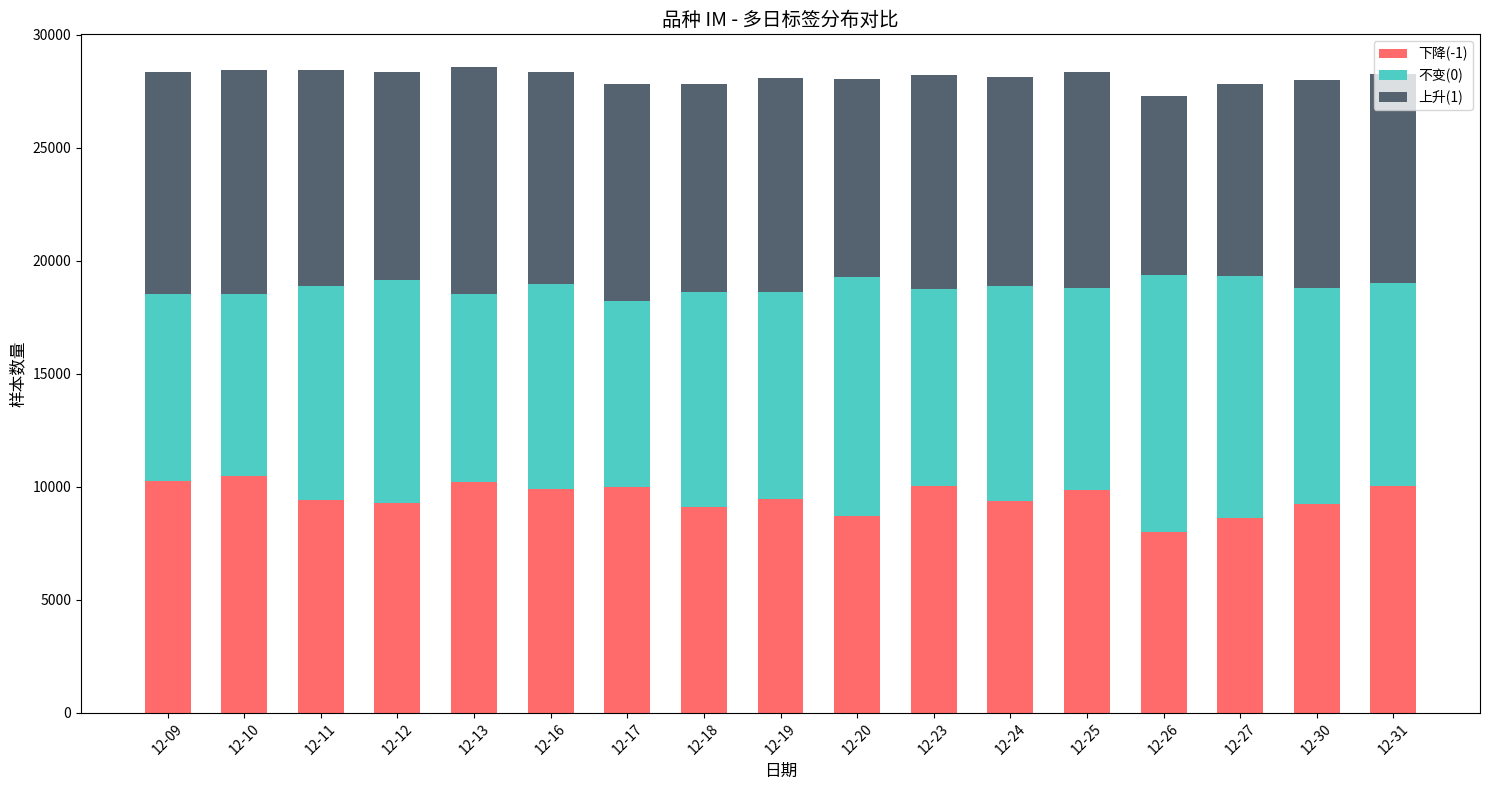

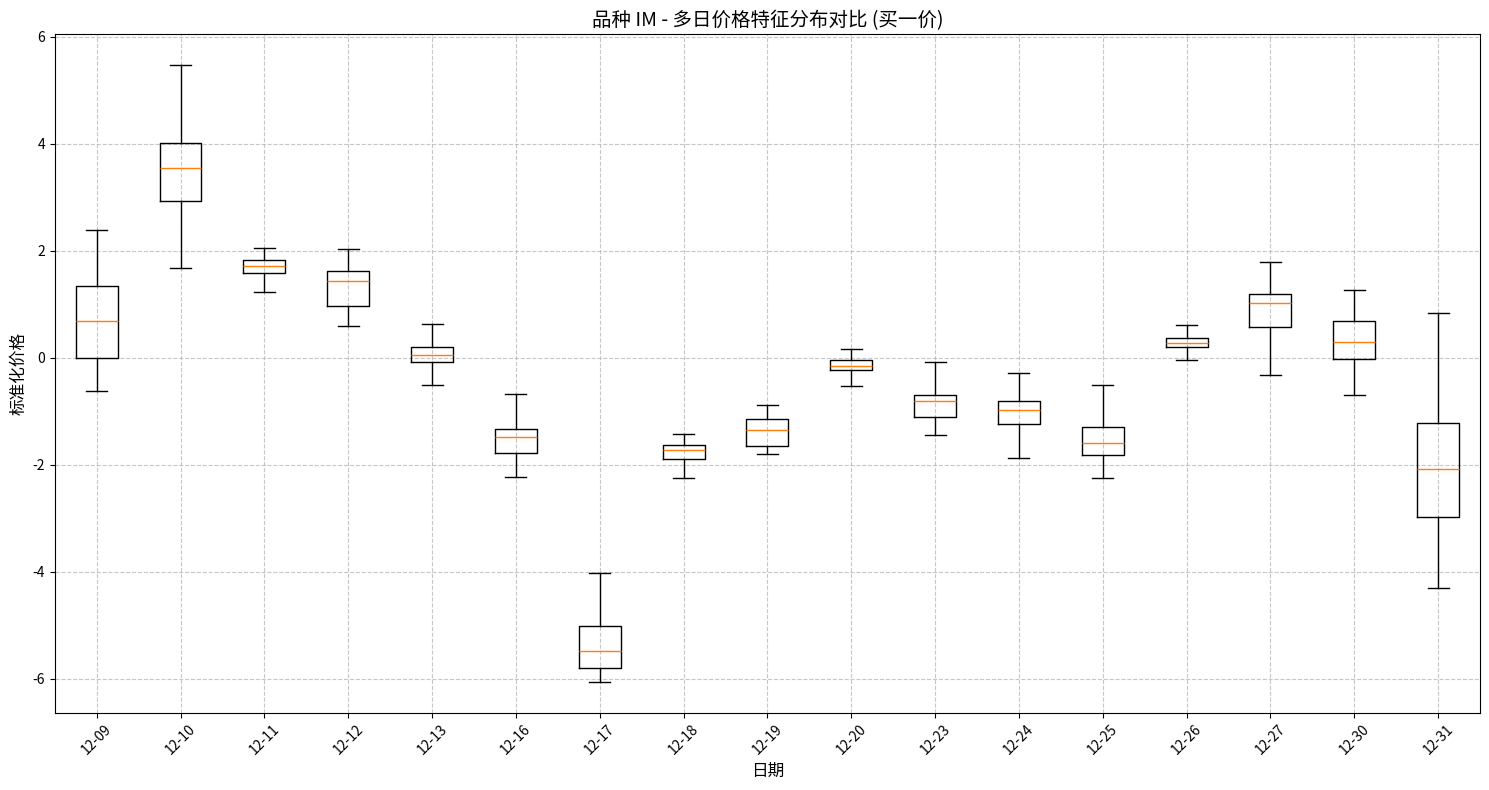

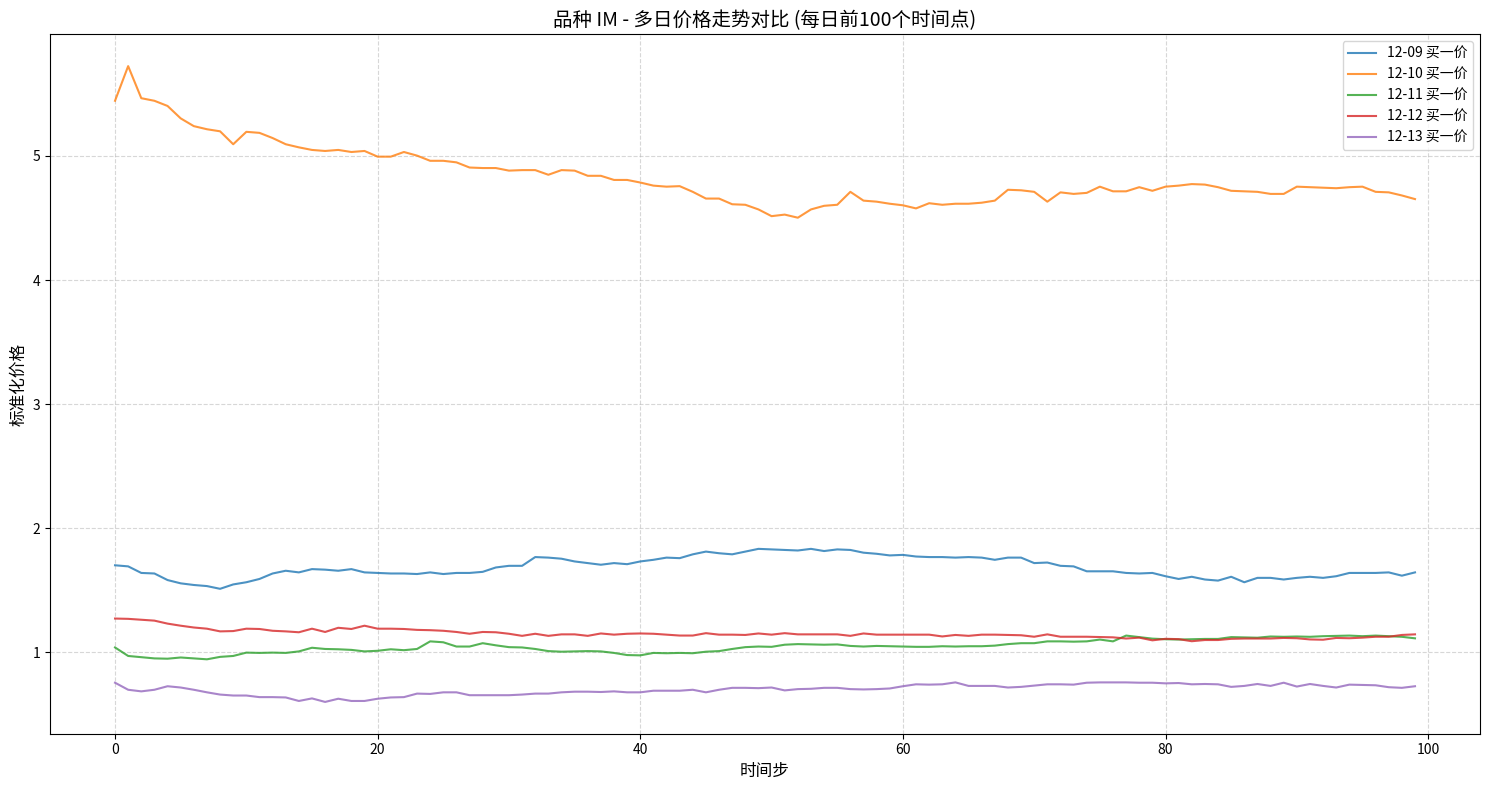

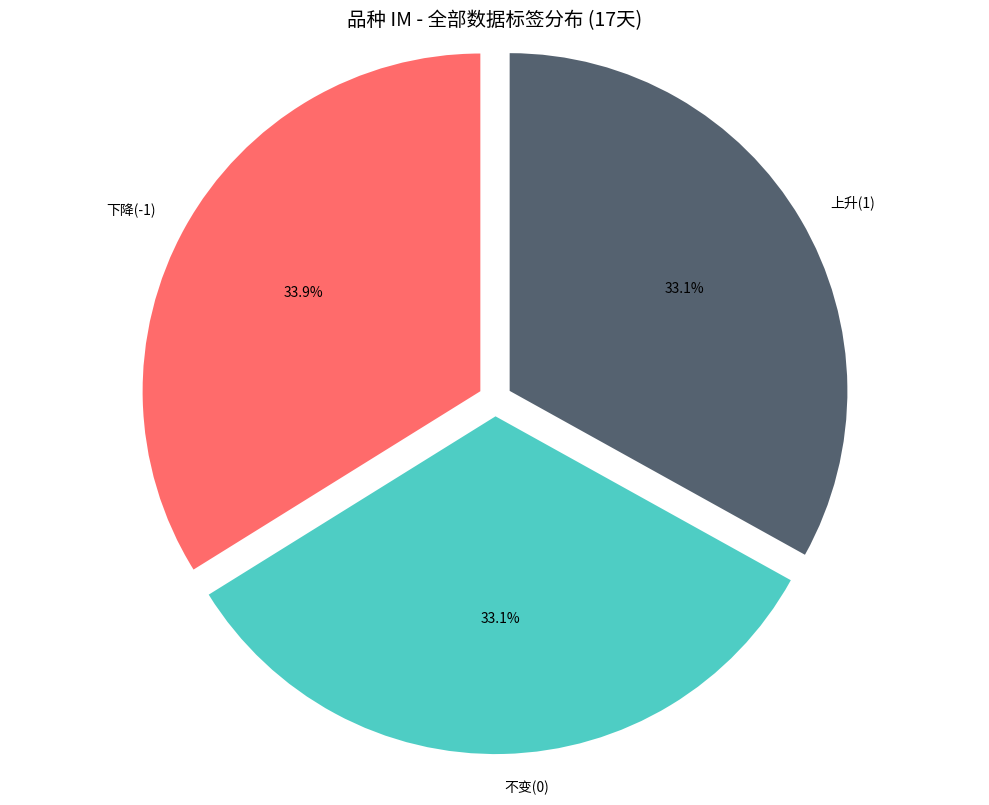

数据已保存到 ./data_cache/IM_daily_norm_data_dict.pkl
数据已保存到 ./data_cache/IM_daily_label_dict.pkl
数据已保存到 ./data_cache/IM_norm_mean_dict.pkl
数据已保存到 ./data_cache/IM_norm_stddev_dict.pkl

IM 数据处理完成并已保存到 ./data_cache 目录


In [9]:
result_by_symbol = process_multi_day_data(
    START_DATE, END_DATE, symbol_types=SYMBOL_TYPES
)

if result_by_symbol:
    # 显示处理后的数据
    print("\n===== 处理后的数据示例 =====")

    # 遍历每个品种
    for symbol_type, data_dict in result_by_symbol.items():
        print(f"\n品种: {symbol_type}")

        # 检查是否有可用的数据
        if not data_dict.get('daily_norm_data_dict'):
            print(f"品种 {symbol_type} 没有足够的数据来生成标准化样本。可能是回看期(LOOKBACK_WINDOW)内的交易日不足。")
            continue

        # 显示日期列表
        available_dates = sorted(list(data_dict['daily_norm_data_dict'].keys()))
        print(f"\n可用日期列表: {available_dates}")

        # 选择一个日期显示数据
        sample_date = available_dates[0]
        print(f"\n日期 {sample_date} 的标准化后数据形状: {data_dict['daily_norm_data_dict'][sample_date].shape}")
        print(f"前5行数据示例:\n{data_dict['daily_norm_data_dict'][sample_date][:5, :10]}")  # 只显示前5行和前10列

        # 显示标签分布
        if sample_date in data_dict['daily_label_dict']:
            labels = data_dict['daily_label_dict'][sample_date]
            unique, counts = np.unique(labels, return_counts=True)
            print(f"\n标签分布: {dict(zip(unique, counts))}")
            print(f"标签示例: {labels[:10].flatten()}")  # 显示前10个标签

        # 生成并显示训练数据形状
        X, y = generate_X_y(data_dict['daily_norm_data_dict'], data_dict['daily_label_dict'])
        if X is not None and y is not None:
            print(f"\n生成的训练数据形状: X: {X.shape}, y: {y.shape}")
            print(f"X示例(第一个样本的前5个时间步和前5个特征):\n{X[0, :5, :5, 0]}")
            print(f"y示例(前5个样本):\n{y[:5]}")

        # 可视化数据
        try:
            visualize_data(data_dict['daily_norm_data_dict'], data_dict['daily_label_dict'], symbol_type=symbol_type)
        except Exception as e:
            print(f"可视化数据时出错: {e}")

        # 保存处理后的数据，以便后续使用
        save_processed_data(data_dict['daily_norm_data_dict'], f'{symbol_type}_daily_norm_data_dict.pkl')
        save_processed_data(data_dict['daily_label_dict'], f'{symbol_type}_daily_label_dict.pkl')
        save_processed_data(data_dict['norm_mean_dict'], f'{symbol_type}_norm_mean_dict.pkl')
        save_processed_data(data_dict['norm_stddev_dict'], f'{symbol_type}_norm_stddev_dict.pkl')

        print(f"\n{symbol_type} 数据处理完成并已保存到 {DATA_CACHE_DIR} 目录")
else:
    # 更新了错误提示信息
    print("数据处理失败，请检查日期范围或本地Parquet文件 'IM00_subset.parquet' 是否存在且包含有效数据。")

我们先尝试TransformerLOB ，是一个强大的时间序列分类模型，结合了卷积、位置编码和 Transformer 编码器，适用于复杂的时间序列数据分析任务。

In [10]:
# cell5: (新版本，适配 TransformerLOB 模型)

# --- 模型参数 ---
D_MODEL = 128            # Transformer内部的工作维度 (必须能被ATTENTION_NUM_HEADS整除)
ATTENTION_NUM_HEADS = 16  # 多头注意力头数 (8个头，128/8=16)
NUM_ENCODER_LAYERS = 3   # Transformer编码器层数
DIM_FEEDFORWARD = 256    # 前馈网络维度
MODEL_DROPOUT = 0.2      # Transformer通常用稍小的Dropout

# --- 训练参数 ---
BATCH_SIZE = 256
NUM_EPOCHS = 100
PATIENCE = 15
LEARNING_RATE = 3e-4     # Transformer对学习率更敏感，通常从一个较小的值开始
TEST_SIZE = 0.2

In [11]:
# cell6 (全新版本: TransformerLOB 模型)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import math

# --- 1. 自定义数据集和早停类 (保持不变) ---
# 这部分代码和您原来的一样，这里为了完整性再次包含
class DeepLOBDataset(Dataset):
    def __init__(self, features, labels, device=None):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        if device is not None:
            self.features = self.features.to(device)
            self.labels = self.labels.to(device)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_metric_min = -float('inf') # 监控F1分数，所以初始值是负无穷
        self.delta = delta
        self.path = path

    def __call__(self, val_f1_score, model):
        score = val_f1_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1_score, model)
        elif score < self.best_score + self.delta: # F1分数应该越大越好
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1_score, model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, val_f1_score, model):
        if self.verbose:
            print(f'Validation F1 score improved ({self.val_metric_min:.6f} --> {val_f1_score:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_metric_min = val_f1_score

# --- 2. TransformerLOB 模型定义 ---

# 辅助模块: 位置编码 (Positional Encoding)
# Transformer没有时序概念，需要我们手动给它加上位置信息
# class PositionalEncoding(nn.Module):
#    def __init__(self, d_model, max_len=5000):
#        super(PositionalEncoding, self).__init__()
#        pe = torch.zeros(max_len, d_model)
#        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#        pe[:, 0::2] = torch.sin(position * div_term)
#        pe[:, 1::2] = torch.cos(position * div_term)
#        pe = pe.unsqueeze(0).transpose(0, 1)
#        self.register_buffer('pe', pe)
#
#    def forward(self, x):
#        # x 的形状是 (timestep, batch, d_model)
#        x = x + self.pe[:x.size(0), :]
#        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # 创建一个可学习的embedding层
        self.pos_embedding = nn.Embedding(max_len, d_model)

    def forward(self, x):
        # x 的形状是 (timestep, batch, d_model)
        # 创建位置索引
        positions = torch.arange(0, x.size(0), device=x.device).unsqueeze(1) # -> (timestep, 1)
        # 查找位置编码并加到输入上
        return x + self.pos_embedding(positions)

class TransformerLOB(nn.Module):
    def __init__(self, feature_num, d_model=128, nhead=8, num_encoder_layers=3, dim_feedforward=256, dropout=0.1):
        """
        一个基于纯Transformer的订单簿预测模型。

        参数:
        - feature_num: 输入特征的数量 (例如，您筛选后的40个)
        - d_model: Transformer内部的工作维度，必须能被nhead整除
        - nhead: 多头注意力的头数
        - num_encoder_layers: Transformer编码器层的数量
        - dim_feedforward: 编码器中前馈网络的维度
        - dropout: Dropout比率
        """
        super().__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model

        # 1. 输入层：将原始特征投影到Transformer的工作维度 (d_model)
        # 我们用一个1D卷积来实现，这很高效，可以看作一个作用于特征维度的线性层
        self.input_proj = nn.Conv1d(in_channels=feature_num, out_channels=d_model, kernel_size=1)

        # 2. 位置编码
        self.pos_encoder = PositionalEncoding(d_model)

        # 3. Transformer编码器
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # 关键参数，让输入可以是 (batch, seq_len, features)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)

        # 4. 输出分类器
        # 我们对所有时间步的输出取平均，然后进行分类
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 3)
        )

        self._init_weights()

        self.attentive_pool = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.Tanh(),
            nn.Linear(d_model // 2, 1)
        )

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        # x: (batch, timestep, features, 1)
        x = x.squeeze(-1)  # -> (batch, timestep, features)

        # --- 输入投影 ---
        # 卷积需要 (batch, channels, length) 的格式，我们这里的特征是channels
        x = x.permute(0, 2, 1)  # -> (batch, features, timestep)
        x = self.input_proj(x)   # -> (batch, d_model, timestep)
        x = x.permute(0, 2, 1)  # -> (batch, timestep, d_model)

        # --- 添加位置编码 ---
        # PositionalEncoding需要 (timestep, batch, d_model)
        x = x.permute(1, 0, 2)  # -> (timestep, batch, d_model)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # -> (batch, timestep, d_model)

        # --- 通过Transformer编码器 ---
        output = self.transformer_encoder(x)  # -> (batch, timestep, d_model)

        # --- 决策 ---
        # output 的形状是 (batch, timestep, d_model)
        # 1. 计算每个时间步的权重
        final_representation = output[:, -1, :]  # -> (batch, d_model)

        # --- 分类 ---
        logits = self.classifier(final_representation)
        return logits

# --- 3. 新的模型初始化函数 ---
def initiate_transformer_model(feature_num, **kwargs):
    """
    初始化 TransformerLOB 模型
    """
    print("正在初始化 TransformerLOB 模型...")
    model = TransformerLOB(
        feature_num=feature_num,
        d_model=kwargs.get('d_model', 128),
        nhead=kwargs.get('nhead', 8),
        num_encoder_layers=kwargs.get('num_encoder_layers', 3),
        dim_feedforward=kwargs.get('dim_feedforward', 256),
        dropout=kwargs.get('dropout', 0.1)
    )
    return model

这个选参部分并没有让模型更好，先注释掉，后期进行修正

In [12]:
# # ==============================================================================
# #                 特征选择单元格 (Feature Selection Cell)
# #
# # 目的: 使用一个快速的 LightGBM 模型来分析所有原始特征的重要性，
# #       输出应保留的原始特征索引列表（按重要性排序取前 N 个）。
# #
# # 使用方法:
# #   1) 先运行前面的数据处理单元格，通常会得到 X 和 y_one_hot；
# #      若未定义，本单元格会尝试从 result_by_symbol 自动生成。
# #   2) 单独运行本单元格。
# #   3) 复制打印出来的 important_feature_indices 到后续单元使用。
# # ==============================================================================

# import lightgbm as lgb
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# print("--- 特征选择流程开始 ---")

# # ---------------- 第 1 步：准备数据（展平时序） ----------------
# print("步骤 1/4: 正在准备数据...")

# # 若 X / y_one_hot 未定义，尝试从 result_by_symbol 自动生成
# if 'X' not in globals() or 'y_one_hot' not in globals():
#     print("[提示] 未检测到 X / y_one_hot，尝试从 result_by_symbol 自动生成…")
#     if 'result_by_symbol' in globals() and 'generate_X_y' in globals():
#         # 任选一个品种；如需固定请手动改成 'IM' 等
#         symbol_type = next(iter(result_by_symbol.keys()))
#         daily_norm  = result_by_symbol[symbol_type]['daily_norm_data_dict']
#         daily_label = result_by_symbol[symbol_type]['daily_label_dict']
#         X, y_one_hot = generate_X_y(daily_norm, daily_label)
#         print(f"[OK] 生成 X={X.shape}, y_one_hot={y_one_hot.shape} (symbol={symbol_type})")
#     else:
#         raise RuntimeError("X / y_one_hot 未定义，且无法从 result_by_symbol 构造。请先运行数据处理单元格。")

# num_samples, num_timesteps, num_features, _ = X.shape
# flat_X   = X.reshape(num_samples, num_timesteps * num_features)
# y_labels = np.argmax(y_one_hot, axis=1)
# print(f"数据准备完毕。原始特征数: {num_features}, 展平特征数: {flat_X.shape[1]}")

# # ---------------- 第 2 步：按时间切分并训练 LGBM ----------------
# print("\n步骤 2/4: 正在训练 LightGBM 以评估特征重要性…")

# TEST_SIZE = globals().get('TEST_SIZE', 0.2)  # 若外部未定义，默认0.2
# train_size = int(len(flat_X) * (1 - TEST_SIZE))

# X_train_full_lgb, X_test_lgb = flat_X[:train_size], flat_X[train_size:]
# y_train_full_lgb, y_test_lgb = y_labels[:train_size], y_labels[train_size:]

# # 从训练末尾切 10% 做验证
# val_size = int(len(X_train_full_lgb) * 0.1)
# X_val_lgb, y_val_lgb = X_train_full_lgb[-val_size:], y_train_full_lgb[-val_size:]
# X_train_lgb, y_train_lgb = X_train_full_lgb[:-val_size], y_train_full_lgb[:-val_size]

# # —— 最小改动：在分割边界留“gap”，避免窗口重叠导致评估偏乐观 ——
# # gap = (窗口长度-1) + 未来步K；若 K 未定义则取 0
# gap = (num_timesteps - 1) + (globals().get('K', 0))
# if gap > 0:
#     # Train→Val 留缝
#     X_train_lgb, y_train_lgb = X_train_lgb[:-gap], y_train_lgb[:-gap]
#     # Val→Test 留缝（即使本 cell 不评测 test，这样更稳）
#     X_val_lgb,   y_val_lgb   = X_val_lgb[:-gap],   y_val_lgb[:-gap]

# print(f"[gap={gap}] train={len(X_train_lgb)}, val={len(X_val_lgb)}, test={len(X_test_lgb)}, total={len(flat_X)}")

# # 定义并训练 LGBM（多分类）
# lgbm_model = lgb.LGBMClassifier(
#     objective='multiclass',
#     metric='multi_logloss',
#     n_estimators=1000,
#     learning_rate=0.05,
#     random_state=42,
#     n_jobs=-1,
#     colsample_bytree=0.8,
#     subsample=0.8
# )
# lgbm_model.fit(
#     X_train_lgb, y_train_lgb,
#     eval_set=[(X_val_lgb, y_val_lgb)],
#     callbacks=[lgb.early_stopping(100, verbose=False)]
# )
# print("LightGBM 模型训练完成。")

# # ---------------- 第 3 步：汇总“原始特征”的总重要性 ----------------
# print("\n步骤 3/4: 正在计算每个原始特征的总重要性…")

# # 生成特征名（展平顺序：先 time 再 feature，匹配上面的 reshape）
# original_feature_names = [f'feature_{i}' for i in range(num_features)]
# feature_names = [f'{name}_t-{t}' for t in range(num_timesteps) for name in original_feature_names]

# feature_importance_df = pd.DataFrame({
#     'feature': feature_names,
#     'importance': lgbm_model.feature_importances_
# })
# # 解析出原始特征索引（如 'feature_58_t-0' → 58）
# feature_importance_df['original_feature_index'] = feature_importance_df['feature'].apply(
#     lambda x: int(x.split('_')[1])
# )

# # 按“原始特征索引”汇总（把同一原始特征在各时间步的贡献加总）
# original_feature_importance = (
#     feature_importance_df
#     .groupby('original_feature_index')['importance']
#     .sum()
#     .sort_values(ascending=False)
#     .to_frame()
# )

# print("原始特征重要性计算完毕。")

# # ---------------- 第 4 步：筛选前 N 个原始特征并可视化 ----------------
# print("\n步骤 4/4: 正在筛选并打印最终要保留的特征列表…")

# NUM_FEATURES_TO_KEEP = 40  # 可按需调整
# important_features_df = original_feature_importance.head(NUM_FEATURES_TO_KEEP)
# important_indices = sorted(important_features_df.index.tolist())

# num_kept = len(important_indices)
# num_dropped = num_features - num_kept

# print("\n--- 特征选择完成 ---")
# print(f"筛选策略: 保留最重要的 {NUM_FEATURES_TO_KEEP} 个原始特征")
# print(f"原始总特征数: {num_features}")
# print(f"筛选后保留特征数: {num_kept}")
# print(f"被剔除的冗余/弱特征数: {num_dropped}")

# print("\n=============== 最终结果 ================")
# print("important_feature_indices =", important_indices)
# print("=========================================\n")

# # 可视化
# plt.figure(figsize=(15, 7))
# plot_df = original_feature_importance.sort_index()  # 为了按索引递增显示
# plot_df['importance'].plot(kind='bar', alpha=0.8)
# plot_df.loc[important_indices, 'importance'].plot(kind='bar', alpha=0.8)
# plt.title('每个原始特征的总重要性得分（红色=选中）', fontsize=16)
# plt.xlabel('原始特征索引', fontsize=12)
# plt.ylabel('总重要性 (LightGBM)', fontsize=12)
# plt.xticks(rotation=90)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.legend(['未选中', '选中'])
# plt.tight_layout()
# plt.show()



==================== 处理品种: IM ====================
特征数据形状: (478177, 59)
标签数据形状: (478177, 1)
筛选前 X 的形状: (478168, 10, 59, 1)
筛选后 X 的形状: (478168, 10, 59, 1) 
IM 训练集形状: X_train (344269, 10, 59, 1), y_train (344269, 3)
IM 验证集形状: X_val (38241, 10, 59, 1), y_val (38241, 3)
IM 测试集形状: X_test (95634, 10, 59, 1), y_test (95634, 3)
使用设备: cuda:0
类别计数: [118410 110118 115741]
类别权重: [2.9074318 3.1263645 2.9744775]
正在初始化 TransformerLOB 模型...
TransformerLOB(
  (input_proj): Conv1d(59, 128, kernel_size=(1,), stride=(1,))
  (pos_encoder): PositionalEncoding(
    (pos_embedding): Embedding(5000, 128)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Line

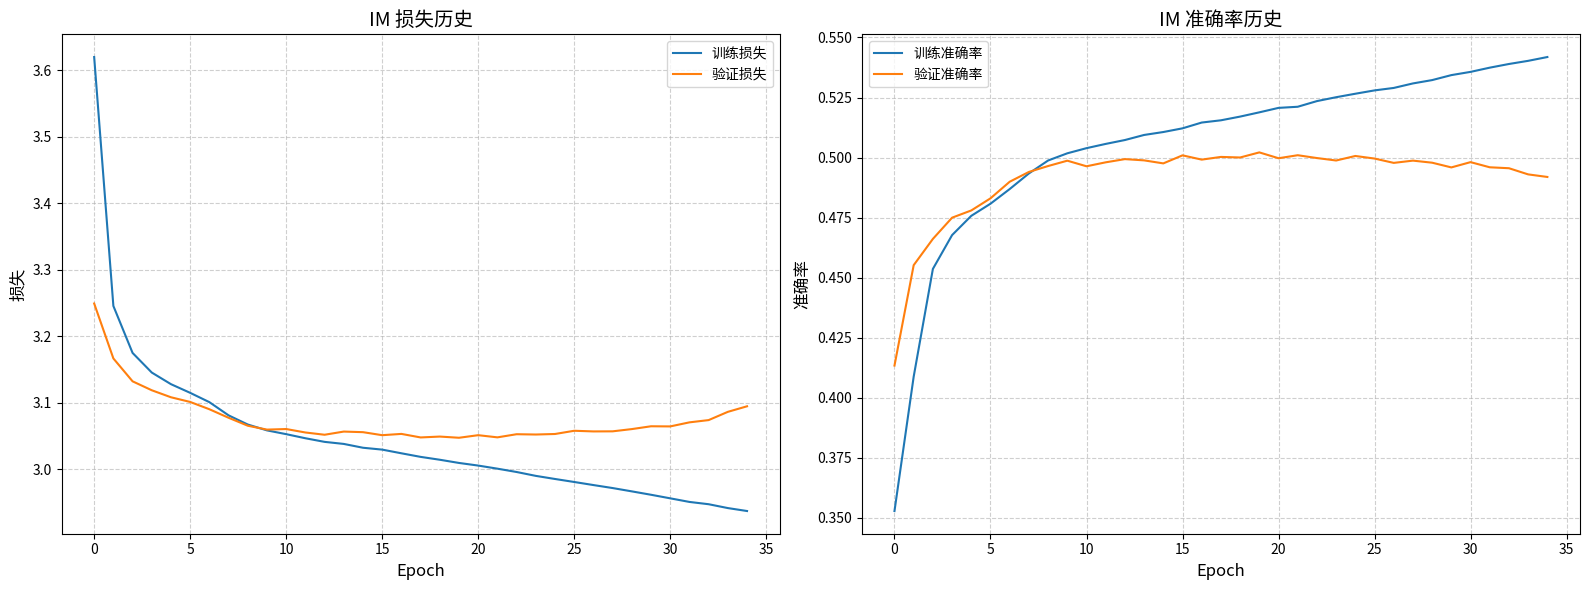

混淆矩阵图已保存至: ./data_cache/visualizations/IM_confusion_matrix.png


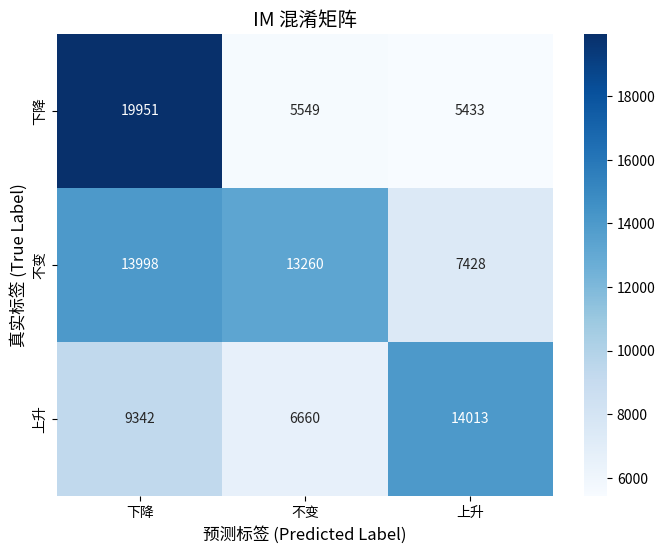


所有品种处理完成


In [13]:
import math
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns

# --- 辅助函数 ---

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1):
    """创建带有预热和余弦衰减的学习率调度器。"""
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

def plot_confusion_matrix(y_true, y_pred, class_labels, symbol_type):
    """绘制并保存混淆矩阵图。"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{symbol_type} 混淆矩阵', fontsize=14)
    plt.ylabel('真实标签 (True Label)', fontsize=12)
    plt.xlabel('预测标签 (Predicted Label)', fontsize=12)

    vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
    os.makedirs(vis_output_dir, exist_ok=True)

    save_path = os.path.join(vis_output_dir, f'{symbol_type}_confusion_matrix.png')
    plt.savefig(save_path)
    print(f"混淆矩阵图已保存至: {save_path}")
    plt.show()

def plot_training_history(history, symbol_type):
    """绘制并保存训练和验证的损失/准确率历史曲线。"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 绘制损失历史
    ax1.plot(history['train_loss'], label='训练损失')
    ax1.plot(history['val_loss'], label='验证损失')
    ax1.set_title(f'{symbol_type} 损失历史', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('损失', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # 绘制准确率历史
    ax2.plot(history['train_acc'], label='训练准确率')
    ax2.plot(history['val_acc'], label='验证准确率')
    ax2.set_title(f'{symbol_type} 准确率历史', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('准确率', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
    os.makedirs(vis_output_dir, exist_ok=True)

    save_path = os.path.join(vis_output_dir, f'{symbol_type}_training_history.png')
    plt.savefig(save_path)
    print(f"训练历史图已保存至: {save_path}")
    plt.show()


for symbol_type in SYMBOL_TYPES:
    print(f"\n{'='*20} 处理品种: {symbol_type} {'='*20}")

    try:
        daily_norm_data_dict = load_processed_data(f'{symbol_type}_daily_norm_data_dict.pkl')
        daily_label_dict = load_processed_data(f'{symbol_type}_daily_label_dict.pkl')
        if daily_norm_data_dict is None or daily_label_dict is None:
            print(f"未找到 {symbol_type} 的缓存数据，跳过训练。")
            continue
    except FileNotFoundError:
        print(f"缓存文件未找到，跳过 {symbol_type} 的训练。")
        continue

    X, y_one_hot = generate_X_y(daily_norm_data_dict, daily_label_dict)
    if X is None or y_one_hot is None:
        print(f"为 {symbol_type} 生成数据失败，跳过训练。")
        continue

    important_feature_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58]
    print(f"筛选前 X 的形状: {X.shape}")
    X = X[:, :, important_feature_indices, :]
    print(f"筛选后 X 的形状: {X.shape} ")

    # 1. 按时间顺序划分，后 TEST_SIZE 比例作为测试集
    train_size = int(len(X) * (1 - TEST_SIZE))
    X_train_full, X_test = X[:train_size], X[train_size:]
    y_train_full, y_test = y_one_hot[:train_size], y_one_hot[train_size:]

    # 2. 从训练集末尾划出 10% 作为验证集
    val_size = int(len(X_train_full) * 0.1)
    X_val, y_val = X_train_full[-val_size:], y_train_full[-val_size:]
    X_train, y_train = X_train_full[:-val_size], y_train_full[:-val_size]

    # 3. 最小改动：在分割边界各留一个 gap（L-1+K；你现在=12）
    gap = (TIMESTAMP_PER_SAMPLE - 1) + K
    X_train, y_train = X_train[:-gap], y_train[:-gap]   # Train→Val 留缝
    X_val,   y_val   = X_val[:-gap],   y_val[:-gap]     # Val→Test 留缝


    print(f"{symbol_type} 训练集形状: X_train {X_train.shape}, y_train {y_train.shape}")
    print(f"{symbol_type} 验证集形状: X_val {X_val.shape}, y_val {y_val.shape}")
    print(f"{symbol_type} 测试集形状: X_test {X_test.shape}, y_test {y_test.shape}")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 3. 类别权重（只基于训练集计算）
    y_train_indices = np.argmax(y_train, axis=1)
    class_counts = np.bincount(y_train_indices, minlength=3)
    if 0 in class_counts:
        print(f"警告: 训练集中存在样本数量为0的类别，无法计算权重。跳过 {symbol_type}。")
        continue
    total_samples = class_counts.sum()
    class_weights = torch.tensor([total_samples / count for count in class_counts],
                                 dtype=torch.float).to(device)
    print(f"类别计数: {class_counts}")
    print(f"类别权重: {class_weights.cpu().numpy()}")

    # 4. DataLoader - 按时间顺序采样
    train_dataset = DeepLOBDataset(X_train, y_train, device)
    val_dataset = DeepLOBDataset(X_val, y_val, device)
    test_dataset = DeepLOBDataset(X_test, y_test, device)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 5. 模型 & 优化器 & 调度器
    # lookback_timestep = X_train.shape[1]
    feature_num = X_train.shape[2]
    model_params = {
        'd_model': D_MODEL,
        'nhead': ATTENTION_NUM_HEADS,
        'num_encoder_layers': NUM_ENCODER_LAYERS,
        'dim_feedforward': DIM_FEEDFORWARD,
        'dropout': MODEL_DROPOUT
    }
    # 调用新的Transformer模型初始化函数
    model = initiate_transformer_model(feature_num, **model_params).to(device)
    print(model)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights,label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05)
    num_training_steps = len(train_loader) * NUM_EPOCHS
    num_warmup_steps = len(train_loader) * 15
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    model_save_path = f'./{symbol_type}_transformer_model.pth'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=model_save_path)

    # 6. 训练循环（验证集用于早停）
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, NUM_EPOCHS + 1):
        # ---- 训练阶段 ----
        model.train()
        train_loss, train_corrects = 0.0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_corrects += torch.sum(preds == torch.argmax(labels, dim=1)).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # ---- 验证阶段 ----
        model.eval()
        val_loss, val_corrects = 0.0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                labels_indices = torch.argmax(labels, dim=1)
                val_corrects += torch.sum(preds == labels_indices).item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels_indices.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        val_f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{NUM_EPOCHS} - "
              f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - "
              f"val_f1_macro: {val_f1_macro:.4f} - lr: {optimizer.param_groups[0]['lr']:.6f}")

        if early_stopping(val_f1_macro, model):
            print(f"\n早停触发 (基于 macro F1-score)，在 epoch {epoch} 停止训练")
            break

    # 7. 最终测试集评估
    print("\n--- 模型最终评估 ---")
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    all_preds_final, all_labels_final = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds_final.extend(preds.cpu().numpy())
            all_labels_final.extend(torch.argmax(labels, dim=1).cpu().numpy())

    report = classification_report(
        all_labels_final,
        all_preds_final,
        target_names=CLASS_LABELS,
        zero_division=0
    )
    print(report)

    print(f"\n{symbol_type} Transformer 模型已保存为 '{model_save_path}'")

    # 8. 可视化
    print("\n--- 结果可视化 ---")
    # 绘制训练历史图
    plot_training_history(history, symbol_type)
    # 绘制混淆矩阵
    plot_confusion_matrix(all_labels_final, all_preds_final, CLASS_LABELS, symbol_type)

print("\n所有品种处理完成")

ImprovedDeepLOB 是对原始 DeepLOB 模型的改进版本，结合了 残差卷积块 (ResidualConvBlock)、双向 LSTM 和 多头注意力机制 (Multihead Attention)，并通过残差连接和归一化层增强了模型的稳定性和性能。

In [14]:
# --- 模型参数 ---
# CNN部分
CNN_FILTERS_1 = 16      # 第一个卷积层的滤波器数量
CNN_FILTERS_2 = 32      # 第二个卷积层的滤波器数量

# LSTM部分
LSTM_HIDDEN_UNITS = 32  # LSTM隐藏单元数量
LSTM_NUM_LAYERS = 2     # LSTM层数

# Attention部分
ATTENTION_NUM_HEADS = 4 # 多头注意力头数

# 通用参数
MODEL_DROPOUT = 0.5     # 模型中统一的Dropout率
LEAKY_RELU_ALPHA = 0.01 # LeakyReLU的alpha参数 (虽然新模型用ReLU，但保留以备用)

# --- 训练参数 ---
BATCH_SIZE = 512      # 新模型可能对显存更友好，可以适当调大Batch Size
NUM_EPOCHS = 100        # 由于模型更简单，可能不需要那么多Epochs，可以先设为100
PATIENCE = 15           # 早停的耐心值
LEARNING_RATE = 5e-4    # 这种模型通常对稍大的学习率更不敏感，可以从1e-3开始尝试
TEST_SIZE = 0.2         # 测试集比例

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F

class ResidualConvBlock(nn.Module):
    """
    A residual block for 1D convolutions.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Shortcut connection to match dimensions if in_channels != out_channels
        if in_channels == out_channels:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False), # 1x1 conv for projection
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += residual  # Add the residual
        return F.relu(out) # Apply final activation

# --- 1. 自定义数据集和早停类 (保持不变) ---
class DeepLOBDataset(Dataset):
    def __init__(self, features, labels, device=None):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        if device is not None:
            self.features = self.features.to(device)
            self.labels = self.labels.to(device)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_metric_min = float('inf')
        self.delta = delta
        self.path = path

    # 修改为监控验证集F1分数
    def __call__(self, val_f1_score, model):
        score = val_f1_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1_score, model)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1_score, model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, val_f1_score, model):
        if self.verbose:
            print(f'Validation F1 score improved ({self.val_metric_min:.6f} --> {val_f1_score:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_metric_min = val_f1_score


# --- 2. 新模型: ImprovedDeepLOB ---
class ImprovedDeepLOB(nn.Module):
    def __init__(self, feature_num,
                 cnn_filters_1=32, cnn_filters_2=64,
                 lstm_hidden_dim=64, lstm_num_layers=2,
                 attention_num_heads=4,
                 dropout=0.3):
        super().__init__()

        # --- MODIFIED: Use ResidualConvBlock instead of nn.Sequential ---
        self.cnn_block1 = ResidualConvBlock(1, cnn_filters_1)
        self.cnn_block2 = ResidualConvBlock(cnn_filters_1, cnn_filters_2)

        # --- NEW: Projection for LSTM residual connection ---
        # This layer will match the dimensions of LSTM input to LSTM output
        self.lstm_input_proj = nn.Linear(feature_num * cnn_filters_2, lstm_hidden_dim * 2)

        # --- MODIFIED: LSTM layer remains the same ---
        self.lstm = nn.LSTM(
            input_size=feature_num * cnn_filters_2,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_num_layers,
            batch_first=True,
            dropout=dropout if lstm_num_layers > 1 else 0,
            bidirectional=True
        )

        # --- NEW: Layer Normalization for post-LSTM and post-Attention ---
        self.norm_lstm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.norm_attn = nn.LayerNorm(lstm_hidden_dim * 2)

        # --- MODIFIED: Attention layer remains the same ---
        self.attention = nn.MultiheadAttention(
            embed_dim=lstm_hidden_dim * 2,
            num_heads=attention_num_heads,
            dropout=dropout,
            batch_first=True
        )

        # --- MODIFIED: Classifier remains the same ---
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim * 2, lstm_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_dim, 3)
        )

        self._init_weights()

    def _init_weights(self):
        # Weight initialization is even more important with deeper/residual nets
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm1d, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x: (batch, timestep, features, 1)
        batch_size, timestep, features, _ = x.shape
        x = x.squeeze(-1) # -> (batch, timestep, features)

        # --- CNN Feature Extraction ---
        x_reshaped = x.reshape(batch_size * timestep, 1, features) # -> (B*T, 1, F)

        # --- MODIFIED: Pass through residual CNN blocks ---
        cnn_out = self.cnn_block1(x_reshaped)
        cnn_out = self.cnn_block2(cnn_out)

        lstm_input_features = cnn_out.reshape(batch_size, timestep, -1) # -> (B, T, cnn_filters_2 * F)

        # --- LSTM with Residual Connection and LayerNorm ---
        lstm_out, _ = self.lstm(lstm_input_features)  # -> (B, T, hidden*2)

        # --- NEW: Add residual connection around LSTM ---
        residual_lstm = self.lstm_input_proj(lstm_input_features) # Project input to match output dim
        lstm_out = self.norm_lstm(lstm_out + residual_lstm) # Add & Norm

        # --- Attention with Residual Connection and LayerNorm (Standard Transformer Block) ---
        # Query, Key, and Value are all the output from the LSTM layer
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)

        # --- NEW: Add residual connection around Attention ---
        attn_out = self.norm_attn(attn_out + lstm_out) # Add & Norm

        # --- Decision ---
        # Take the last time step's output for classification
        final_representation = attn_out[:, -1, :]  # -> (B, hidden*2)

        # --- Classifier ---
        logits = self.classifier(final_representation)
        return logits

def initiate_DeepLOB_model(feature_num, **kwargs):
    """
    初始化 ImprovedDeepLOB 模型
    """
    print("正在初始化 ImprovedDeepLOB 模型...")
    model = ImprovedDeepLOB(
        feature_num=feature_num,
        cnn_filters_1=kwargs.get('cnn_filters_1', 32),
        cnn_filters_2=kwargs.get('cnn_filters_2', 64),
        lstm_hidden_dim=kwargs.get('lstm_hidden_dim', 64),
        lstm_num_layers=kwargs.get('lstm_num_layers', 2),
        attention_num_heads=kwargs.get('attention_num_heads', 4),
        dropout=kwargs.get('dropout', 0.3)
    )
    return model


==================== 处理品种: IM ====================
特征数据形状: (478177, 59)
标签数据形状: (478177, 1)
筛选前 X 的形状: (478168, 10, 59, 1)
筛选后 X 的形状: (478168, 10, 59, 1) 
使用设备: cuda:0
类别计数: [118410 110118 115741]
类别权重: [2.9074318 3.1263645 2.9744775]
正在初始化 ImprovedDeepLOB 模型...
ImprovedDeepLOB(
  (cnn_block1): ResidualConvBlock(
    (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 16, kernel_size=(1,), stride=(1,), bias=False)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (cnn_block2): ResidualConvBlock(
    (conv1): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, 

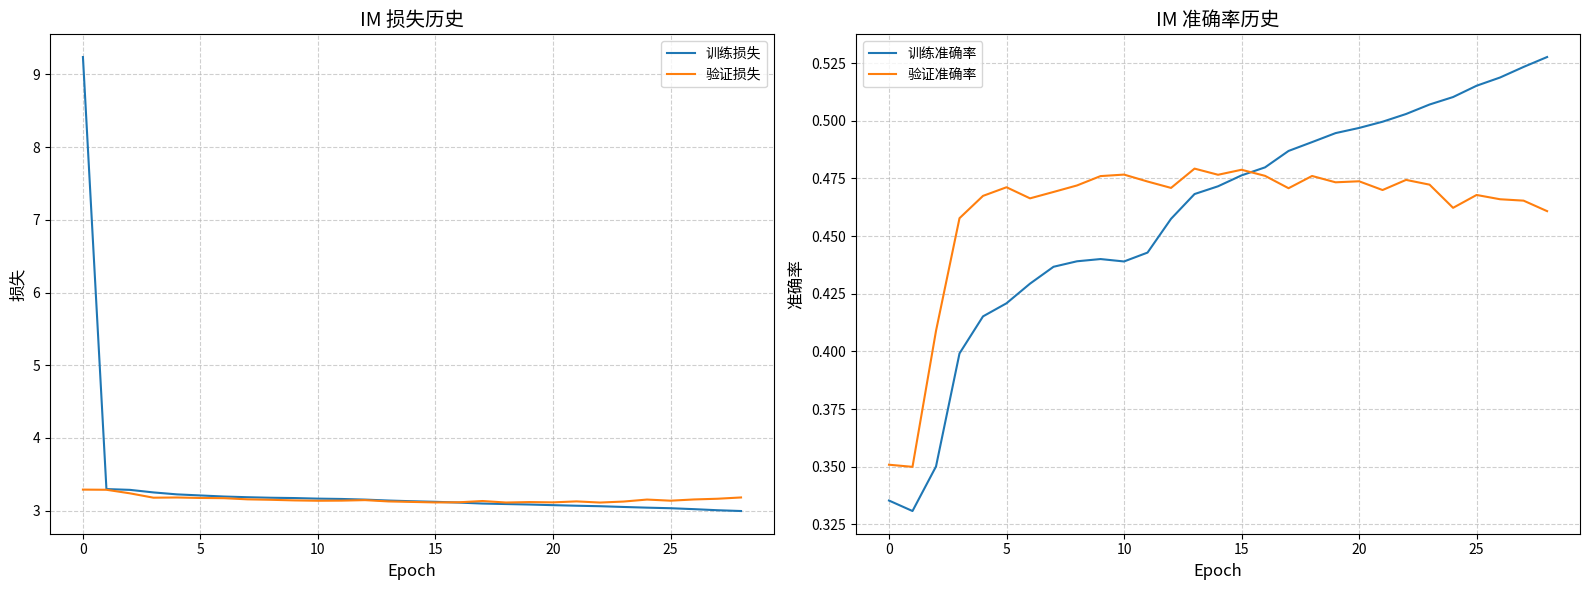

混淆矩阵图已保存至: ./data_cache/visualizations/IM_confusion_matrix.png


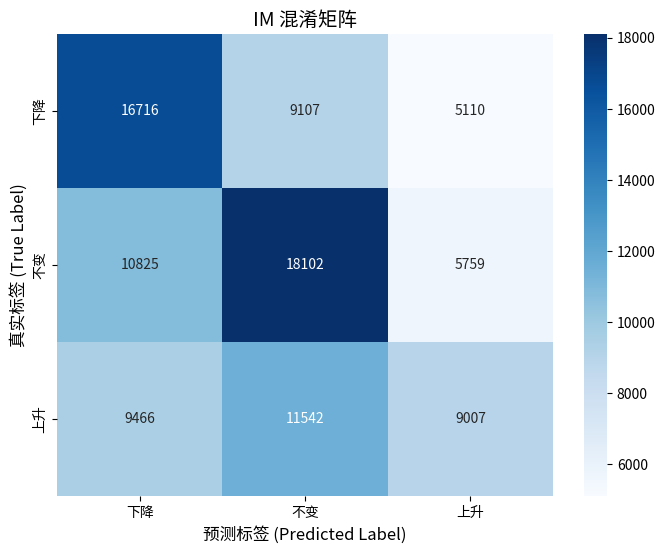


所有品种处理完成


In [16]:
import math
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns


def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1):
    """创建带有预热和余弦衰减的学习率调度器。"""
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

def plot_confusion_matrix(y_true, y_pred, class_labels, symbol_type):
    """绘制并保存混淆矩阵图。"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{symbol_type} 混淆矩阵', fontsize=14)
    plt.ylabel('真实标签 (True Label)', fontsize=12)
    plt.xlabel('预测标签 (Predicted Label)', fontsize=12)

    vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
    os.makedirs(vis_output_dir, exist_ok=True)

    save_path = os.path.join(vis_output_dir, f'{symbol_type}_confusion_matrix.png')
    plt.savefig(save_path)
    print(f"混淆矩阵图已保存至: {save_path}")
    plt.show()

def plot_training_history(history, symbol_type):
    """绘制并保存训练和验证的损失/准确率历史曲线。"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 绘制损失历史
    ax1.plot(history['train_loss'], label='训练损失')
    ax1.plot(history['val_loss'], label='验证损失')
    ax1.set_title(f'{symbol_type} 损失历史', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('损失', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # 绘制准确率历史
    ax2.plot(history['train_acc'], label='训练准确率')
    ax2.plot(history['val_acc'], label='验证准确率')
    ax2.set_title(f'{symbol_type} 准确率历史', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('准确率', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    vis_output_dir = os.path.join(DATA_CACHE_DIR, "visualizations")
    os.makedirs(vis_output_dir, exist_ok=True)

    save_path = os.path.join(vis_output_dir, f'{symbol_type}_training_history.png')
    plt.savefig(save_path)
    print(f"训练历史图已保存至: {save_path}")
    plt.show()


for symbol_type in SYMBOL_TYPES:
    print(f"\n{'='*20} 处理品种: {symbol_type} {'='*20}")

    try:
        daily_norm_data_dict = load_processed_data(f'{symbol_type}_daily_norm_data_dict.pkl')
        daily_label_dict = load_processed_data(f'{symbol_type}_daily_label_dict.pkl')
        if daily_norm_data_dict is None or daily_label_dict is None:
            print(f"未找到 {symbol_type} 的缓存数据，跳过训练。")
            continue
    except FileNotFoundError:
        print(f"缓存文件未找到，跳过 {symbol_type} 的训练。")
        continue

    X, y_one_hot = generate_X_y(daily_norm_data_dict, daily_label_dict)
    if X is None or y_one_hot is None:
        print(f"为 {symbol_type} 生成数据失败，跳过训练。")
        continue


    important_feature_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58]
    print(f"筛选前 X 的形状: {X.shape}")
    X = X[:, :, important_feature_indices, :]
    print(f"筛选后 X 的形状: {X.shape} ")

    # 1. 按时间顺序划分，后 TEST_SIZE 比例作为测试集
    train_size = int(len(X) * (1 - TEST_SIZE))
    X_train_full, X_test = X[:train_size], X[train_size:]
    y_train_full, y_test = y_one_hot[:train_size], y_one_hot[train_size:]

    # 2. 从训练集末尾划出 10% 作为验证集
    val_size = int(len(X_train_full) * 0.1)
    X_val, y_val = X_train_full[-val_size:], y_train_full[-val_size:]
    X_train, y_train = X_train_full[:-val_size], y_train_full[:-val_size]

    # 3. 最小改动：在分割边界各留一个 gap（L-1+K；你现在=12）
    gap = (TIMESTAMP_PER_SAMPLE - 1) + K
    X_train, y_train = X_train[:-gap], y_train[:-gap]   # Train→Val 留缝
    X_val,   y_val   = X_val[:-gap],   y_val[:-gap]     # Val→Test 留缝


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 3. 类别权重（只基于训练集计算）
    y_train_indices = np.argmax(y_train, axis=1)
    class_counts = np.bincount(y_train_indices, minlength=3)
    if 0 in class_counts:
        print(f"警告: 训练集中存在样本数量为0的类别，无法计算权重。跳过 {symbol_type}。")
        continue
    total_samples = class_counts.sum()
    class_weights = torch.tensor([total_samples / count for count in class_counts],
                                 dtype=torch.float).to(device)
    print(f"类别计数: {class_counts}")
    print(f"类别权重: {class_weights.cpu().numpy()}")

    # 4. DataLoader - 按时间顺序采样
    train_dataset = DeepLOBDataset(X_train, y_train, device)
    val_dataset = DeepLOBDataset(X_val, y_val, device)
    test_dataset = DeepLOBDataset(X_test, y_test, device)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 5. 模型 & 优化器 & 调度器
    # lookback_timestep = X_train.shape[1]
    feature_num = X_train.shape[2]
    model_params = {
    'cnn_filters_1': CNN_FILTERS_1,
    'cnn_filters_2': CNN_FILTERS_2,
    'lstm_hidden_dim': LSTM_HIDDEN_UNITS,
    'lstm_num_layers': LSTM_NUM_LAYERS,
    'attention_num_heads': ATTENTION_NUM_HEADS,
    'dropout': MODEL_DROPOUT
    }
    model = initiate_DeepLOB_model(feature_num, **model_params).to(device)
    print(model)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights,label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05)
    num_training_steps = len(train_loader) * NUM_EPOCHS
    num_warmup_steps = len(train_loader) * 5
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    model_save_path = f'./{symbol_type}_transformer_model.pth'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=model_save_path)

    # 6. 训练循环（验证集用于早停）
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, NUM_EPOCHS + 1):
        # ---- 训练阶段 ----
        model.train()
        train_loss, train_corrects = 0.0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_corrects += torch.sum(preds == torch.argmax(labels, dim=1)).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # ---- 验证阶段 ----
        model.eval()
        val_loss, val_corrects = 0.0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                labels_indices = torch.argmax(labels, dim=1)
                val_corrects += torch.sum(preds == labels_indices).item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels_indices.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        val_f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{NUM_EPOCHS} - "
              f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - "
              f"val_f1_macro: {val_f1_macro:.4f} - lr: {optimizer.param_groups[0]['lr']:.6f}")

        if early_stopping(val_f1_macro, model):
            print(f"\n早停触发 (基于 macro F1-score)，在 epoch {epoch} 停止训练")
            break

    # 7. 最终测试集评估
    print("\n--- 模型最终评估 ---")
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    all_preds_final, all_labels_final = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds_final.extend(preds.cpu().numpy())
            all_labels_final.extend(torch.argmax(labels, dim=1).cpu().numpy())

    report = classification_report(
        all_labels_final,
        all_preds_final,
        target_names=CLASS_LABELS,
        zero_division=0
    )
    print(report)

    print(f"\n{symbol_type} Transformer 模型已保存为 '{model_save_path}'")

    # 8. 可视化
    print("\n--- 结果可视化 ---")
    # 绘制训练历史图
    plot_training_history(history, symbol_type)
    # 绘制混淆矩阵
    plot_confusion_matrix(all_labels_final, all_preds_final, CLASS_LABELS, symbol_type)

print("\n所有品种处理完成")